In [27]:
import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal as mv_norm
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
%matplotlib inline

## Functions to Generate the Training and Test Datasets

####  Details of target function generation
The target function at each node is generated as follows:
$T = \mathbf{a}^T\phi(\mathbf{X}) + Z$, where 

$\mathbf{X} = [X_1, X_2, \ldots, X_N]^T$ denotes the random data point,

$\phi(\mathbf{X}) = [1, X_1, X_2, \ldots, X_N]^T$ denotes the feature vector obtained from data point,

$\mathbf{a} = [a_0, a_1, \ldots, a_N]^T$ denotes the weight vector, 

$Z$ denotes Gaussian noise with zero mean and $T$ denotes the target value. 

For simplicity we assume $Z \sim \mathcal{N}(0, \beta^{-1})$, where $\beta$ denotes the precision. Hence the target values $T \sim \mathcal{N}(\mathbf{a}^T\phi(\mathbf{X}), \beta^{-1})$ 

Therefore the likelihood of $T = t$ given $\mathbf{X} = \mathbf{x}$ denoted by $p(t|\mathbf{x}, \mathbf{a})$ has the Gaussian distribution $\mathcal{N}(\mathbf{a}^T\phi(\mathbf{x}), \beta^{-1})$ whose likelihood is given by $G(t, \mathbf{a}^T\phi(\mathbf{x}), \beta^{-1})$


In [111]:
# x_vec = [x1, x2, ... , xi] and xi is available to node i only
def real_function(a_vec, noise_sigma, X):
    
    N = X.shape[0]
    N_samples = X.shape[1]
    
    #Evaluates the real function
    f_value = a_vec[0]
    for i in range(0, N):
        f_value += a_vec[i+1]*X[i,:]
    if noise_sigma==0:
        # Recovers the true function
        return f_value
    else:
        return f_value + normal(0, noise_sigma, N_samples)

#### Details of data points generation across the network
Data point $\mathbf{X} = [X_1, X_2, \ldots, X_N]^T$ is an $N$ dimensional vector, where each $X_i \sim Unif[l_i, u_i]$.

In [126]:
# generate training set for each node
def generate_training_set(l_vec, u_vec, a_vec, noise_sigma, N_samples):
    # generates N_samples copies of X which are uniformly distributed over [l,u]
    N = len(l_vec)
    X = np.zeros((N, N_samples), dtype=float)
    for i in range(0,N):
        X[i, :] = uniform(l_vec[i], u_vec[i], N_samples)    
    # Evaluate the real function for training example inputs
    t = real_function(a_vec, noise_sigma, X)

    return X, t

## Training and Testing Procedure

### Training at each node without cooperation

We consider a network of $N$ nodes. We generate $N$ datasets network wide.

For node $i$:

Each node $i$'s local and private dataset is denoted by $\mathcal{D}_i = \{(\mathbf{X}_i^{(j)}, t^{(j)}), j \in \{1,2, \ldots, N_{0}\}\}$, where each $\mathbf{X}_i^{(j)}$ is an $N$ dimensional data point.

Using the given dataset $\mathcal{D}_i$ at node $i$, we want to able to predict $t$ given a new input $\mathbf{x}$, i.e, make a prediction based the following predictive distribution 
\begin{align}
p(t|\mathbf{x}, \mathcal{D}_i)
\end{align}

The predictive distribution can be obtained as follows 
\begin{align}
p(t|\mathbf{x}, \mathcal{D}_i) &= \int p(t, \mathbf{a}|\mathbf{x}, \mathcal{D}_i)d\mathbf{a}  \\
& = \int p(t|\mathbf{x}, \mathbf{a}, \mathcal{D}_i)p(\mathbf{a}|\mathcal{D}_i)d\mathbf{a}   \\
& = \int p(t|\mathbf{x}, \mathbf{a})p(\mathbf{a}|\mathcal{D}_i)d\mathbf{a} 
\end{align}

We train each node using the dataset $\mathcal{D}_i$ to obtain $p(\mathbf{a}|\mathcal{D}_i)$. We obtain the posterior distribution on weight vector $\mathbf{a}$ is a Bayesian fashion, i.e., we start with a prior on $\mathbf{a}$ given by 
\begin{align}
p(\mathbf{a}) = G(\mathbf{a}, \boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0)
\end{align}

For simplicity we consider $\boldsymbol{\mu}_0 = 0$ and $\boldsymbol{\Sigma}_0 = \alpha^{-1}I$.

We update the posterior distribution on $\mathbf{a}$ in an online fashion or sequential fashion as we observe the data. Let $\boldsymbol{\mu}^{(k)}_i$ and $\boldsymbol{\Sigma}^{(k)}_i$ denote the mean and covariance matrix of the posterior distribution after observing $k$ samples from $\mathcal{D}_i$. Then, after observing $k+1$th point $(\mathbf{x}_i^{(k+1)}, t_i^{(k+1)})$ we use Bayes rule (for more details on Bayesian linear regression please refer to Bishop's treatment of the Bayesian approach to linear regression.) to obtain $\boldsymbol{\mu}^{(k+1)}_i$ and $\boldsymbol{\Sigma}^{(k+1)}_i$ as follows

\begin{align}
(\boldsymbol{\Sigma}^{(k+1)}_i)^{-1} 
&= (\boldsymbol{\Sigma}^{(k)}_i)^{-1} + \beta \phi(\mathbf{x}_i^{(k+1)})^T\phi(\mathbf{x}_i^{(k+1)}) 
\\
\boldsymbol{\mu}^{(k+1)}_i 
&= \boldsymbol{\Sigma}^{(k+1)}_i\left((\boldsymbol{\Sigma}^{(k)}_i)^{-1} \boldsymbol{\mu}_i^{(k)} + \beta \phi(\mathbf{x}_i^{(k+1)})^T t_i^{(k+1)} \right)
\end{align}

Update using the above equations until we have looped through the entire local datasets.

### Training at each node with peer-to-peer cooperation

Again we want to train each node using the dataset $\mathcal{D}_i$ and cooperation with neighbors in the graph given by social interaction matrix $\mathbf{W}$ to obtain $p^{(k)}(\mathbf{a})$ after each node has observed $k$ training samples.

We obtain the posterior distribution on weight vector $\mathbf{a}$ is a Bayesian fashion, i.e., we start with a prior on $\mathbf{a}$ given by 
\begin{align}
p^{(0)}(\mathbf{a}) = G(\mathbf{a}, \boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0)
\end{align}

For simplicity we consider $\boldsymbol{\mu}_0 = 0$ and $\boldsymbol{\Sigma}_0 = \alpha^{-1}I$.

$\underline{\text{Local Bayesian Update Step:}}$

We update the posterior distribution on $\mathbf{a}$ in an online fashion or sequential fashion as we observe the data. Let $\boldsymbol{\mu}^{(k)}_i$ and $\boldsymbol{\Sigma}^{(k)}_i$ denote the mean and covariance matrix of the posterior distribution after observing $k$ samples from $\mathcal{D}_i$. Then, after observing $k+1$th point $(\mathbf{x}_i^{(k+1)}, t_i^{(k+1)})$ we use Bayesian update to obtain $\boldsymbol{\mu}^{(k+1)}_i$ and $\boldsymbol{\Sigma}^{(k+1)}_i$ as follows

\begin{align}
(\boldsymbol{\Sigma}^{(k+1)}_i)^{-1} 
&= (\boldsymbol{\Sigma}^{(k)}_i)^{-1} + \beta \phi(\mathbf{x}_i^{(k+1)})^T\phi(\mathbf{x}_i^{(k+1)}) 
\\
\boldsymbol{\mu}^{(k+1)}_i 
&= \boldsymbol{\Sigma}^{(k+1)}_i\left((\boldsymbol{\Sigma}^{(k)}_i)^{-1} \boldsymbol{\mu}_i^{(k)} + \beta \phi(\mathbf{x}_i^{(k+1)})^T t_i^{(k+1)} \right)
\end{align}

$\underline{\text{Consensus Step:}}$

The merged covariance matrix $\overline{\boldsymbol{\Sigma}}^{(k+1)}_i$ for node $i$ is given as
\begin{align}
(\overline{\boldsymbol{\Sigma}}^{(k+1)}_i)^{-1}  =  \sum_{j = 1}^N W_{ij}(\boldsymbol{\Sigma}_j^{(k+1)})^{-1}.
\end{align}

The merged mean value for node $i$ is given as
\begin{align}
\overline{\boldsymbol{\mu}}^{(k+1)}_i =  \overline{\boldsymbol{\Sigma}}^{(k+1)}_i\sum_{j=1}^N W_{ij}(\boldsymbol{\Sigma}_j^{(k+1)})^{-1}\mu_j .
\end{align}


Update using the above equations until we have looped through the entire local datasets.

### Prediction on the test dataset at each node

The predictive distribution on plugging in the values gives us 
\begin{align}
p(t| \mathbf{x}) &= \int p(t| \mathbf{x}, \mathbf{a}) p^{(N_0)}(\mathbf{a})d\mathbf{a}
\\
& = \int G(t, \mathbf{a}^T\phi(\mathbf{x}), \beta^{-1}) G(\mathbf{a}, \overline{\boldsymbol{\mu}}^{(N_0)}_i, \overline{\boldsymbol{\Sigma}}^{(N_0)}_i) d\mathbf{a}
\\
& = G(t, (\overline{\boldsymbol{\mu}}^{(N_0)}_i)^T\phi(\mathbf{x}), \overline{\boldsymbol{\Sigma}}^{\ast}_i),
\end{align}

where 
\begin{align}
\overline{\boldsymbol{\Sigma}}^{\ast}_i = \beta^{-1} + \phi(\mathbf{x})^T\overline{\boldsymbol{\Sigma}}^{(N_0)}_i \phi(\mathbf{x})
\end{align}

## Initialize the Linear Bayes Class Object

#### Details of each node and its posterior distribution

Each node has access to $\mathbf{X}_i = [X_{1i}, X_{2i}, \ldots, X_{iN}]$ which an $N$ dimensional data point. However $\mathbf{X}_i \in \mathcal{X}_i \subset \mathbb{R}^N$, where $\mathcal{X}_i$ denotes the local data space.

In [297]:
class LinearSeqBayes(object):
    """
    A class that holds parameter prior/posterior and handles 
    the hyper-parameter updates with new data
    
    Note:  variables starting with "_vec" indicate Nx1 dimensional 
        column vectors, those starting with "_mat" indicate 
        matrices, and those starting with "_arr" indicate 
        1xN dimensional arrays.
    
    Args:
        meam0_arr (np.array): prior mean vector of size 1xM
        covar0_mat (np.ndarray): prior covariance matrix of size MxM
        beta (float): known real-data noise precision
        
    """
    def __init__(self, mean0_arr, covar0_mat, beta):
        self.prior = mv_norm(mean=mean0_arr, cov=covar0_mat)
        self.meanPrev_vec = mean0_arr.reshape(mean0_arr.shape + (1,)) #reshape to column vector
        self.covarPrev_mat = covar0_mat
        self.beta = beta
        
        self.meanCurrent_vec = self.meanPrev_vec
        self.covarCurrent_mat = self.covarPrev_mat
        self.posterior = self.prior
        self.prediction = self.prior
        
    def get_phi_mat(self, X):
        N = X.shape[0]
        phi_mat = np.ones((X.shape[0]+1, X.shape[1]))
        for i in range(0,N):
            phi_mat[i,:] = X[i,:]
        return phi_mat
        
    def get_phi(self, x_vec):
        """
        Note that the other terms in x_vec are not from other nodes
        in the network. These are local N dimensional data points
        If some dimensions are not seen at node i they are set to zero
        """
        N = len(x_vec)
        phi_vec = np.ones((1, N+1)) 
        for i in range(0,N):
            phi_vec[:, i] = x_vec[i]
        return phi_vec
    
    def set_posterior(self, x_vec, t):
        """
        Updates current mean vec and covariance matrix given x and t value
        """
        phi_vec = self.get_phi(x_vec)
        
        self.covarCurrent_mat = np.linalg.inv(np.linalg.inv(self.covarPrev_mat) + self.beta*phi_vec.T.dot(phi_vec))
        self.meanCurrent_vec = self.covarCurrent_mat.dot(np.linalg.inv(self.covarPrev_mat).dot(self.meanPrev_vec)) + \
                                      self.covarCurrent_mat.dot(self.beta*phi_vec.T.dot(t))
        
        self.posterior = mv_norm(mean=self.meanCurrent_vec.flatten(), cov=self.covarCurrent_mat)
        

        
    def merge_PosteriorParams(self, W_vec, meanCurrent_dict, covarCurrent_mat_dict):
        
        N = len(W_vec)
        dummy_mean = np.zeros((N+1,1), dtype = float)
        dummy_covar =  np.zeros((N+1,N+1), dtype = float)
        
        for i in range(0,N):
            dummy_mean += np.linalg.inv(covarCurrent_mat_dict[i]).dot(meanCurrent_dict[i])*W_vec[i]
            dummy_covar +=  np.linalg.inv(covarCurrent_mat_dict[i])*W_vec[i]

        self.covarCurrent_mat = np.linalg.inv(dummy_covar)
        self.meanCurrent_vec = self.covarCurrent_mat.dot(dummy_mean)
        
        
    def update_prevPosteriorParams(self):
        # update the previous mean and covariance to new updated one using one sample (x_vec,t)
        self.covarPrev_mat = self.covarCurrent_mat
        self.meanPrev_vec = self.meanCurrent_vec    
        
    def predict_test_set(self,X):
        N_samples = X.shape[1]
        x_mat = self.get_phi_mat(X)
        
        predictions = []
        for idx in range(0,N_samples):
            x = x_mat[:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.covarCurrent_mat.dot(x))
            mean_x = self.meanCurrent_vec.T.dot(x)
            predictions.append(normal(mean_x.flatten(), np.sqrt(sig_sq_x)))
        return np.array(predictions)
    
    def compute_mse(self, t, predictions):
        N = len(t)
        err = np.array(t-predictions)
        err = np.square(err)
        return sum(err)/N
    
    def make_scatter(self, x1_arr, x2_arr, t_arr, real_parms, samples=None, stdevs=None):
        """
        A helper function to plot noisy data, the true function, 
        and optionally a set of lines specified by the nested array of
        weights of size NxM where N is number of lines, M is 2 for 
        this simple model
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        ax.scatter(x1_arr, x2_arr, t_arr, alpha=0.5)
        ax.set_xlabel('x_1')
        ax.set_ylabel('x_2')
        ax.set_zlabel('t')

        x1, x2 = np.mgrid[-1:1:.01, -1.5:1.5:.01]
        x = np.stack((x1,x2))
        ax.plot_surface(x1, x2, real_function(a_vec, 0, x), cmap=cm.coolwarm)

        _ = plt.title('Real Data from Noisy Linear Function')

### Bayesian Linear Regression for single node

In [249]:
# Real function parameters
N_train = 500

a_0 = -0.3
a_1 = 0.5
a_2 = 0.8
a_vec = np.array([a_0, a_1, a_2])

l1 = -1
u1 = 1
l2 = -1.5
u2 = 1.5

l_vec = np.array([l1, l2])
u_vec = np.array([u1, u2])

noise_sigma = 0.8
beta = 1/noise_sigma**2
# Generate input features from uniform distribution
np.random.seed(20) # Set the seed so we can get reproducible results

# generates N training samples
[X_train_mat, t_train_vec] = generate_training_set(l_vec, u_vec, a_vec, noise_sigma, N_train)
N_test = int(N_train/5)
[X_test_mat,t_test_vec] = generate_training_set(l_vec, u_vec, a_vec, noise_sigma, N_test)

mse_vec = np.zeros((N_train), dtype = float)

In [263]:
alpha = 2.0
mean0_vec = np.array([0., 0., 0.])
covar0_mat = 1/alpha*np.identity(3)

linbayes = LinearSeqBayes(mean0_vec, covar0_mat, beta)

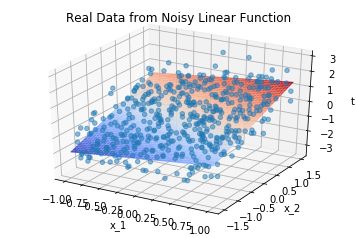

In [243]:
linbayes.make_scatter(X_train_mat[0,:], X_train_mat[1,:], t_train_vec, real_parms = [a_0, a_1, a_2])

#### Main Training loop: Training averaged over multiple sample paths

In [162]:
max_runs = 500

avg_mse_vec = np.zeros((N_train), dtype = float)

for t in range(0, max_runs):
    
    # generates N training samples
    [X_train_mat, t_train_vec] = generate_training_set(l_vec, u_vec, a_vec, noise_sigma, N_train)
    N_test = int(N_train/5)
    [X_test_mat, t_test_vec] = generate_training_set(l_vec, u_vec, a_vec, noise_sigma, N_test)

    mse_vec = np.zeros((N_train), dtype = float)
    
    alpha = 2.0
    mean0_vec = np.array([0., 0., 0.])
    covar0_mat = 1/alpha*np.identity(3)

    linbayes = LinearSeqBayes(mean0_vec, covar0_mat, beta)
    
    for n in range(0, N_train):
        linbayes.set_posterior(X_train_mat[:,n], t_train_vec[n])
        linbayes.update_prevPosteriorParams()
        predictions_vec = linbayes.predict_test_set(X_test_mat)
        mse_vec[n] = linbayes.compute_mse(t_test_vec, predictions_vec.flatten())
        
    avg_mse_vec += mse_vec

avg_mse_vec = avg_mse_vec/max_runs 

avg_mse_vec_1node = avg_mse_vec

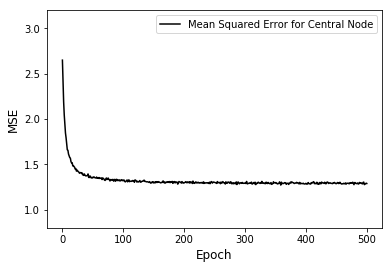

In [164]:
plt.plot(np.linspace(0, N_train, num=N_train), avg_mse_vec_1node,'k', label='Mean Squared Error for Central Node')
plt.xlabel(r'Epoch', fontsize = 12)
plt.ylabel(r'MSE', fontsize = 12)
plt.legend()
plt.ylim([0.8, 3.2])
#plt.xlim([0,500])
plt.savefig('MSEVsIter_1node_LearningGlobal.eps', dpi = 450)
plt.show()

### Bayesian Linear Regression for two nodes without cooperation

In [165]:
# Real function parameters
N_train = 500

a_0 = -0.3
a_1 = 0.5
a_2 = 0.5
a_vec = np.array([a_0, a_1, a_2])

l1 = -1
u1 = 1
l2 = -1.5
u2 = 1.5

l_vec = np.array([l1, l2])
u_vec = np.array([u1, u2])

l1_vec = np.array([l1, 0])
u1_vec = np.array([u1, 0])

l2_vec = np.array([0, l2])
u2_vec = np.array([0, u2])

noise_sigma = 0.8
beta = 1/noise_sigma**2
# Generate input features from uniform distribution
np.random.seed(20) # Set the seed so we can get reproducible results

# generates N training samples for node 1
[X1_train_mat, t1_train_vec] = generate_training_set(l1_vec, u1_vec, a_vec, noise_sigma, N_train)

# generates N training samples for node 2
[X2_train_mat, t2_train_vec] = generate_training_set(l2_vec, u2_vec, a_vec, noise_sigma, N_train)

# common test set
N_test = int(N_train/5)
[X_test_mat, t_test_vec] = generate_training_set(l_vec, u_vec, a_vec, noise_sigma, N_test)

mse_vec_node1 = np.zeros((N_train), dtype = float)
mse_vec_node2 = np.zeros((N_train), dtype = float)

In [166]:
alpha = 2.0
mean0_vec = np.array([0., 0., 0.])
covar0_mat = 1/alpha*np.identity(3)

linbayes_node1 = LinearSeqBayes(mean0_vec, covar0_mat, beta)
linbayes_node2 = LinearSeqBayes(mean0_vec, covar0_mat, beta)

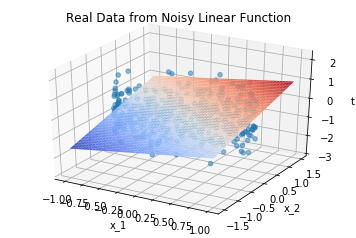

In [168]:
linbayes_node1.make_scatter(X1_train_mat[0,:], X1_train_mat[1,:], t1_train_vec, real_parms = [a_0, a_1, a_2])

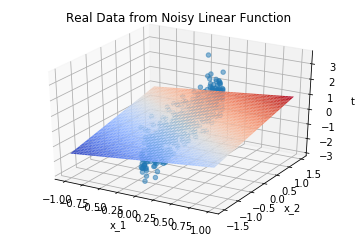

In [169]:
linbayes_node2.make_scatter(X2_train_mat[0,:], X2_train_mat[1,:], t2_train_vec, real_parms = [a_0, a_1, a_2])

#### Main Training loop: Training averaged over multiple sample paths

In [173]:
max_runs = 500

avg_mse_vec_node1 = np.zeros((N_train), dtype = float)
avg_mse_vec_node2 = np.zeros((N_train), dtype = float)

for t in range(0, max_runs):
    
    # generates N training samples for node 1
    [X1_train_mat, t1_train_vec] = generate_training_set(l1_vec, u1_vec, a_vec, noise_sigma, N_train)

    # generates N training samples for node 2
    [X2_train_mat, t2_train_vec] = generate_training_set(l2_vec, u2_vec, a_vec, noise_sigma, N_train)

    # common test set
    N_test = int(N_train/5)
    [X_test_mat, t_test_vec] = generate_training_set(l_vec, u_vec, a_vec, noise_sigma, N_test)

    mse_vec_node1 = np.zeros((N_train), dtype = float)
    mse_vec_node2 = np.zeros((N_train), dtype = float)
    
    alpha = 2.0
    mean0_vec = np.array([0., 0., 0.])
    covar0_mat = 1/alpha*np.identity(3)

    linbayes_node1 = LinearSeqBayes(mean0_vec, covar0_mat, beta)
    linbayes_node2 = LinearSeqBayes(mean0_vec, covar0_mat, beta)
    
    for n in range(0, N_train):
        linbayes_node1.set_posterior(X1_train_mat[:,n], t1_train_vec[n])
        linbayes_node1.update_prevPosteriorParams()
        predictions_vec_node1 = linbayes_node1.predict_test_set(X_test_mat)
        mse_vec_node1[n] = linbayes_node1.compute_mse(t_test_vec, predictions_vec_node1.flatten())
    
        linbayes_node2.set_posterior(X2_train_mat[:,n], t2_train_vec[n])
        linbayes_node2.update_prevPosteriorParams()
        predictions_vec_node2 = linbayes_node2.predict_test_set(X_test_mat)
        mse_vec_node2[n] = linbayes_node2.compute_mse(t_test_vec, predictions_vec_node2.flatten())
 
        
    avg_mse_vec_node1 += mse_vec_node1
    avg_mse_vec_node2 += mse_vec_node2

avg_mse_vec_node1 = avg_mse_vec_node1/max_runs 
avg_mse_vec_node2 = avg_mse_vec_node2/max_runs 

avg_mse_vec_node1_NoCoop = avg_mse_vec_node1 
avg_mse_vec_node2_NoCoop = avg_mse_vec_node2

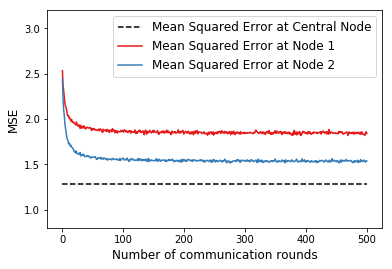

In [174]:
mse_central, = plt.plot(np.linspace(0, N_train, num=N_train), 1.27821171*np.ones((N_train), dtype = float), linestyle= '--', color = [0, 0,0],label='Mean Squared Error at Central Node')

mse_node1, = plt.plot(np.linspace(0, N_train, num=N_train),  avg_mse_vec_node1_NoCoop, color = '#e41a1c',label='Mean Squared Error at Node 1')
mse_node2, = plt.plot(np.linspace(0, N_train, num=N_train),  avg_mse_vec_node2_NoCoop, color = '#377eb8', label='Mean Squared Error at Node 2')
plt.xlabel(r'Number of communication rounds', fontsize=12)
plt.ylabel(r'MSE', fontsize=12)
plt.legend(fontsize=12)
plt.ylim([0.8, 3.2])
plt.savefig('MSEVsIter_2nodes_LearningNoCooperation_centralNode.eps', dpi = 450)
plt.show()

### Bayesian Linear Regression for two nodes with cooperation

In [289]:
# Real function parameters
N_train = 500
N = 2

W = np.array([np.array([0.9, 0.1]), np.array([0.6, 0.4])])

a_0 = -0.3
a_1 = 0.5
a_2 = 0.5
a_vec = np.array([a_0, a_1, a_2])

l1 = -1
u1 = 1
l2 = -1.5
u2 = 1.5

l_vec = np.array([l1, l2])
u_vec = np.array([u1, u2])

l1_vec = np.array([l1, 0])
u1_vec = np.array([u1, 0])

l2_vec = np.array([0, l2])
u2_vec = np.array([0, u2])

noise_sigma = 0.8
beta = 1/noise_sigma**2
# Generate input features from uniform distribution
np.random.seed(20) # Set the seed so we can get reproducible results

#### Main Training Loop: Training averaged over multiple sample paths

In [302]:
max_runs = 500

avg_mse_vec_node1 = np.zeros((N_train), dtype = float)
avg_mse_vec_node2 = np.zeros((N_train), dtype = float)

for t in range(0, max_runs):
    
    # generates N training samples for node 1
    [X1_train_mat, t1_train_vec] = generate_training_set(l1_vec, u1_vec, a_vec, noise_sigma, N_train)

    # generates N training samples for node 2
    [X2_train_mat, t2_train_vec] = generate_training_set(l2_vec, u2_vec, a_vec, noise_sigma, N_train)

    # common test set
    N_test = int(N_train/5)
    [X_test_mat, t_test_vec] = generate_training_set(l_vec, u_vec, a_vec, noise_sigma, N_test)

    mse_vec_node1 = np.zeros((N_train), dtype = float)
    mse_vec_node2 = np.zeros((N_train), dtype = float)
    
    alpha = 2.0
    mean0_vec = np.array([0., 0., 0.])
    covar0_mat = 1/alpha*np.identity(3)

    linbayes_node1 = LinearSeqBayes(mean0_vec, covar0_mat, beta)
    linbayes_node2 = LinearSeqBayes(mean0_vec, covar0_mat, beta)
    
    for n in range(0, N_train):

        # perform local bayesian update at each node
        linbayes_node1.set_posterior(X1_train_mat[:,n], t1_train_vec[n])
        linbayes_node2.set_posterior(X2_train_mat[:,n], t2_train_vec[n])

        # initialize the dictionaries with current posterior parameters
        mean_dict[0] = linbayes_node1.meanCurrent_vec
        mean_dict[1] = linbayes_node2.meanCurrent_vec
        covar_mat_dict[0] = linbayes_node1.covarCurrent_mat
        covar_mat_dict[1] = linbayes_node2.covarCurrent_mat

        # perform the consensus step
        linbayes_node1.merge_PosteriorParams(W[0], mean_dict, covar_mat_dict)
        linbayes_node2.merge_PosteriorParams(W[1], mean_dict, covar_mat_dict)

        # update the local posteriors with merged posteriors
        linbayes_node1.update_prevPosteriorParams()
        linbayes_node2.update_prevPosteriorParams()

        # evaluate on the test dataset
        predictions_vec_node1 = linbayes_node1.predict_test_set(X_test_mat)
        mse_vec_node1[n] = linbayes_node1.compute_mse(t_test_vec, predictions_vec_node1.flatten())
        predictions_vec_node2 = linbayes_node2.predict_test_set(X_test_mat)
        mse_vec_node2[n] = linbayes_node2.compute_mse(t_test_vec, predictions_vec_node2.flatten())
 
    avg_mse_vec_node1 += mse_vec_node1
    avg_mse_vec_node2 += mse_vec_node2

avg_mse_vec_node1 = avg_mse_vec_node1/max_runs 
avg_mse_vec_node2 = avg_mse_vec_node2/max_runs 

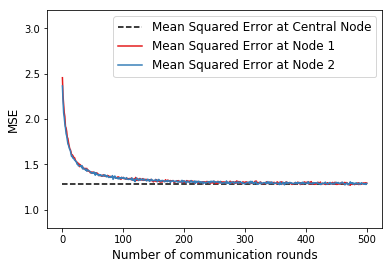

In [303]:

mse_central, = plt.plot(np.linspace(0, N_train, num=N_train), 1.27821171*np.ones((N_train), dtype = float), linestyle= '--', color = [0, 0,0],label='Mean Squared Error at Central Node')

mse_node1, = plt.plot(np.linspace(0, N_train, num=N_train), avg_mse_vec_node1, color = '#e41a1c', label='Mean Squared Error at Node 1')
mse_node2, = plt.plot(np.linspace(0, N_train, num=N_train), avg_mse_vec_node2, color = '#377eb8', label='Mean Squared Error at Node 2')

plt.xlabel(r'Number of communication rounds', fontsize=12)
plt.ylabel(r'MSE', fontsize=12)
plt.legend(fontsize=12)
plt.ylim([0.8, 3.2])
plt.savefig('MSEVsIter_2nodes_LearningWithCoop_centralNode.eps', dpi = 450)
plt.show()